# CSCI 3352 Biological Networks, Spring 2020, Prof. Clauset

# Lecture 8 lab : epidemic simulations

***

**Team names**: 

***

This is an in-class "laboratory," in which you will explore the behavior of the basic SIR model of an epidemic on a network.

The lab is divided into three parts:
1. A warm-up in which you develop intuition about how an epidemic spreads on a network.
* An experiment in which you explore the epidemic threshold of $\beta/\gamma=R_0=1$, and how the shape of an epidemic varies as a function of $R_0$, for a fixed network $G$.
* An experiment in "flattening the epidemic", in which you explore how specific changes to either the epidemic parameters ($\beta$ and $\gamma$) or to the underlying exposure graph $G$, can alter the "length" and "height" of the epidemic.

***
* [Documentation for networkx](https://networkx.github.io/documentation/stable/)

[//]: <> (Documentation for igraph Python https://igraph.org/python/ )

In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import random as rnd
rnd.seed()
import copy

In [2]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    
    node_colors = []
    for i in G.nodes():
        if z[i]=='S':
            cid = 0
        if z[i]=='I':
            cid = 1
        if z[i]=='R':
            cid = 2
        node_colors.append(colors[int(cid)])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
    
    nx.draw_kamada_kawai(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it prettier
    #nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

***
## Part 1 : getting familiar with basic SIR on a network

The code below implements a basic SIR model on a network $G$, where $G$ is the same toy graph used in the lecture notes. It
* sets the SIR parameters to $\beta=\gamma=0.3$
  * uses 2 dictionaries to represent nodes' current (`zt`) and next (`zu`) states so that updating is synchronous
  * use 3 lists $S(t)$,$I(t)$,$R(t)$ to track the number of nodes in each state
* begins by choosing a uniformly random node $i$ to be "patient 0" (set `zt[i]=1`)
* then, applies $S\to I$ updates, by looping over edges
* then, applies $I\to R$ updates, by looping over nodes
* halts when no nodes are in the $I$ state
* then uses `drawGz()` to visualize the epidemic's progression
* and both plots the $S(t)$,$I(t)$,$R(t)$ time series, and reports the number of nodes in $S$ and $R$ at the end

To warm up, run this SIR simulation several times with the given $\beta,\gamma$ parameters and examine both the graph visualizations and the final $S(t)$,$I(t)$,$R(t)$ time series. Consider the following questions:
1. How often does the epidemic infect all or nearly all the nodes?
2. Does _which_ node is patient 0 matter for how far the epidemic spreads?

time step 1


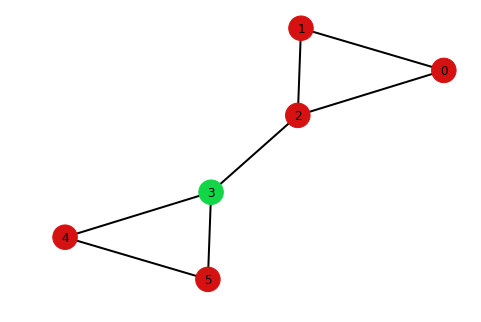

time step 2


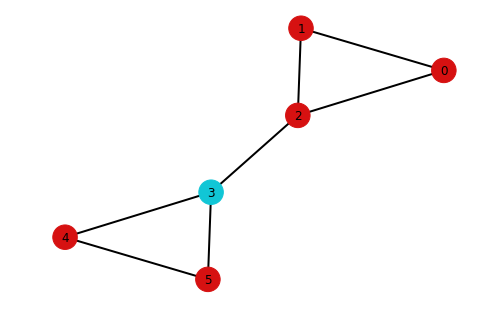

number of steps in epidemic: 1
final number of S: 5
final number of R: 1


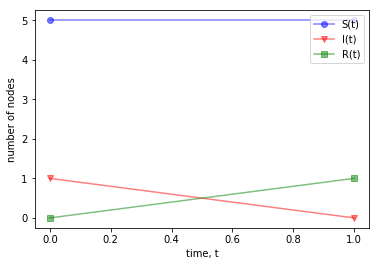

In [4]:
# Basic SIR simulation

G  = nx.Graph([(0,1),(0,2),(1,2),(2,3),(3,4),(3,5),(4,5)]) # a simple graph G

n  = G.order()
zt = dict.fromkeys(range(n), 'S') # all nodes S, initially

beta = 0.3 # probability of {S-I} -> {I-I}
gmma = 0.3 # probability of {I}   -> {R}

St = [] # S(t), time series of number of S nodes per time step t
It = [] # I(t), time series of number of I nodes per time step t
Rt = [] # R(t), time series of number of R nodes per time step t

seed     = int(rnd.randint(0,n-1)) # pick a random node is patient 0
zt[seed] = 'I'
t        = 1

print(f'time step {t}')
drawGz(G,zt)

Sc,Ic,Rc = n-1,1,0 # S,I,R node counts, initial
St.append(Sc)
It.append(Ic)
Rt.append(Rc)
while any(xi == 'I' for xi in zt.values()):
    zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)
    
    # do S -> I transitions
    for e in G.edges():
        i,j = e[0],e[1]           # this edge (i,j)
        if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
            if rnd.random() < beta:
                zu[j] = 'I'       # i infects j for next round
                Sc,Ic = Sc-1,Ic+1 # update counts

        if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
            if rnd.random() < beta:
                zu[i] = 'I'       # j infects i for next round
                Sc,Ic = Sc-1,Ic+1 # update counts

    # do I -> R transitions
    for i in G.nodes():
        if zt[i] == 'I' and rnd.random() < gmma:
            zu[i] = 'R'           # i recovers (R)
            Ic,Rc = Ic-1,Rc+1     # update counts

    # update all states synchronously, update clock
    zt = copy.deepcopy(zu)
    t  = t+1
    print(f'time step {t}')
    drawGz(G,zt)

    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc) # append these counts to the time series

# report how it went
print(f'number of steps in epidemic: {t-1}')
print(f'final number of S: {Sc}')
print(f'final number of R: {Rc}')

# plot the S(t),I(t),R(t) time series nicely
fig = plt.figure()
ax1 = fig.add_subplot(111) # put multiple 
plt.plot(range(t), St, 'bo-', alpha=0.5,label='S(t)')  # plot the log-likelihood trajectory
plt.plot(range(t), It, 'rv-', alpha=0.5,label='I(t)')  # plot the log-likelihood trajectory
plt.plot(range(t), Rt, 'gs-', alpha=0.5,label='R(t)')  # plot the log-likelihood trajectory
plt.ylabel('number of nodes')
plt.xlabel('time, t')
plt.legend(loc='upper right');
plt.show()

***
## Part 2 : varying $\beta$ and $\gamma$

Using the SIR simulation from `Part 1`, conduct the following three mini-experiments. For these, use the built-in `.connected_caveman_graph(l,k)` network generator in `networkx`, with `l=10` (number of cliques) and `k=6` (size of clique).
1. set $\beta/\gamma=0.5$, in the _subcritical_ regime of $R_0$
* set $\beta/\gamma=1$, at the epidemic threshold of $R_0$
* set $\beta/\gamma=2$, in the _supercritical_ regime of $R_0$

You'll want to run each setting several times to get a sense of what the epidemic tends to do. If you aren't able to get much to happen, try increasing the magnitude of $\beta,\gamma$. For each, discuss with your teammates what you see happening, and answer the following specific questions:
1. In each of the three cases, describe in a few words how far the epidemic tends to spread.
* Which edges are the critical ones for spreading the epidemic?
* Recall the classic $S(t)$,$I(t)$,$R(t)$ plot from the lecture; how are these functions similar or different here?
* How do the dynamics change when you set $\beta=\gamma=1$ (the most extreme setting)?

In [ ]:
# epidemic threshold experiments
l,k = 12,6 # l cliques each containing k nodes
G   = nx.connected_caveman_graph(l,k)

# YOUR CODE



Your discussion

***
## Part 3 : flattening an epidemic

Again using the SIR simulation from `Part 1`, conduct the following three mini-experiments. For these, use the built-in `.gnp_random_graph(n, p)` network generator in `networkx`. Recall that `p` is the probability that an edge exists, and we choose it by first choosing the _mean degree_ $c$ (see Lecture Notes 3). The idea here is that the first experiment sets up your baseline for an SIR epidemic on a network, and then we'll first vary one parameter, and then vary a different parameter, to investigate the effects these parameters have on the dynamics of the epidemic. To do this, you'll want to plot the $S(t)$,$I(t)$,$R(t)$ functions after each simulation.

Experiment 3.1: simulate a basic epidemic:
* set $n=200$ and $c=6$
* note around what time step $I(t)$ peaks, and how many time steps it mostly spans.

Experiment 3.2: simulate the effect of reduced transmission (e.g., hand washing!):
* lower $\beta$; keep $\gamma$ the same, $n=200$ and $c=6$

Experiment 3.3: simulate the effect of "social distancing" (e.g., self-quarantine, staying at home, etc.):
* lower $c$ in $G(n,p)$; keep $\beta=\gamma$, $n=200$

As before, you'll want to run each setting several times to get a sense of what the epidemic tends to do. Start by lowering $\beta$ and $c$ only a little, and then keep lowering them until you see something change. Then, discuss with your teammates what you found, and answer the following specific questions:
1. What effect does lowering $\beta$ (reducing the likelihood of transmission) have on $I(t)$, compared to experiment 3.1? How much reduced transmission would you need _everyone_ to do to achieve a real "flattening" of the epidemic? Do you think that's realistic?
* What effect does lowering $c$ (reducing the likelihood of transmission) have on $I(t)$?, compared to experiment 3.1? How much social distancing would you need_everyone_ to do to achieve the results you found in experiment 3.3? (Consider what a typical $c$ might be for _you_ during a normal day. Is $c=6$ realistic?)
* Which has a larger effect on $I(t)$, reduced transmission or social distancing?
* As time allows, run another experiment in which you keep $\beta$ and $c$ the same, but instead increase the recovery rate (e.g., better health care). What effect does this have on $I(t)$, compared to the other experiments?

In [ ]:

# YOUR CODE


Your discussion

***
## Part 4 : explore!

What else can you do with this simulation? Try some things out. Different graphs (see `networkx` for various graph generators), different numbers of states, zombies!, vaccinations, etc.